# Titanic Survival Dataset
<br>

>Attached to this task (helpful links section below) is the Titanic survival dataset. The dataset contains some information about the people on board the Titanic on the tragic night that it sunk.
<br>

- Take a look at the data and clean it. Take a few words to justify your decisions and other reasonable alternatives.

- How does various factors impact survival: age, sex, social class etc?

- What are some potential correlations in the dataset between these factors? How can we account for them?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow.keras.layers import Dense, Layer, Dropout
from tensorflow.keras import Model

In [2]:
class display_data:
    def __init__(self, dataframe=None, column_names=None, dimensions=None):
        '''Initialise default arguments'''
        self.df = dataframe  
        (self.ncols, self.nrows) = dimensions    
        self.column_list = column_names
        
        '''Initialise optional variables'''        
        self.bar_type = 'barh'
        self.group_split = 'Survived'
        self.group_by_list = ['Sex', 'Cabin Class']
        self.legend_list = ['Female', 'Male']
        self.figsize = (10,10)
        self.axes = None
        
        self.box_plot_x = 'Cabin Class'
        self.hue = None
        
        self.class_labels = ["Casualty", "Survived"]
    
        '''Initialise matplotlib figures and dimensions'''
    def initialise_sub_plots(self):
        fig, axs = plt.subplots(nrows=self.nrows, ncols=self.ncols, figsize=self.figsize)
        self.axes = axs.ravel()
        sns.set_theme(style="darkgrid")
        
        '''Display multiple columns'''
    def class_data(self):
        self.initialise_sub_plots()
        for n, column in enumerate(self.column_list):    
            self.df[column].value_counts().plot(kind=self.bar_type, xlabel=column, ylabel='Count', ax = self.axes[n], cmap="summer")
    
        '''Display grouped data'''
    def grouped_data(self):
        self.initialise_sub_plots()
        for n, column in enumerate(self.column_list):
            self.df.loc[self.df[self.group_split] == n].groupby(self.group_by_list).size().reset_index().pivot(columns=self.group_by_list[0], 
            index=self.group_by_list[1], values=0).plot(ax= self.axes[n], kind='bar', stacked=True)
            
            self.axes[n].legend(self.legend_list)
            self.axes[n].set_ylim(0,400)
            self.axes[n].set_title(column)
            
        '''Generate box plots'''
    def box_plot(self):
        self.initialise_sub_plots()
        for n, y_values in enumerate(self.column_list):
            sns.boxplot(x=self.box_plot_x, y=y_values, data=self.df, ax=self.axes[n], hue=self.hue)
            
        '''Display data using sns package'''
    def correlation_sns(self, dataframe_list):
        
        self.initialise_sub_plots()
        cmap = sns.diverging_palette(230,20, as_cmap=True)
        for n, df in enumerate(dataframe_list):
            corr = df.corr()
            mask = np.triu(np.ones_like(corr, dtype=bool))
            self.axes[n].set_title('Multivariate Correlation')
            sns.heatmap(corr, ax=self.axes[n], mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
            
        '''Confusion Matrix display'''
    def confusion_matrix(self, model, df_dict):
        self.initialise_sub_plots()
        for n, label in enumerate(self.class_labels):
            y_pred = model.predict(df_dict[label][0])
            confusion_mtx = tf.math.confusion_matrix(df_dict[label][1], y_pred)
            sns.heatmap(confusion_mtx,
                       annot=True, fmt='g', ax=self.axes[n])
            plt.xlabel('Prediction')
            plt.ylabel('Label')
        

We first load the original dataset to explore the different headers

In [3]:
path = 'C:/Users/maran/OneDrive/Documents/The Self/Kalido/titanic.csv'
original_df = pd.read_csv(path)
original_df.head()

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3 pclass,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,1,1 pclass,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,1,3 pclass,Miss. Laina Heikkinen,female,26.0,0,0,7.9250
3,1,1 pcl,Mrs. Jacques Heath (Lily May Peel) Futrelle,NaN,35.0,1,0,53.1000
4,0,3 pclass,Mr. William Henry Allen,male,35.0,0,0,8.0500


## Cleaning dataset

Explore the statement based columns to view the different classes and how they are balanced. Create a function to display multiple classes of data.

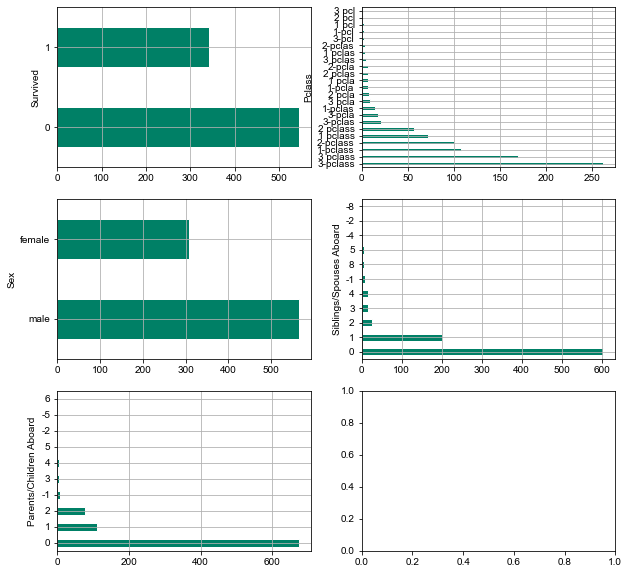

In [4]:
column_names = ['Survived','Pclass', 'Sex', 'Siblings/Spouses Aboard','Parents/Children Aboard']
display_data_obj = display_data(original_df, column_names, dimensions=(2,3))
display_data_obj.class_data()

There are numerous duplicates for the cabin classes. Take the first chracter of the unique class names existing, create a corresponding key, add it to a dictionary

In [5]:
class_dict = {}
for value in original_df['Pclass'].values:
    class_dict[value] = int(value[0])
original_df = original_df.rename(columns={"Pclass":"Cabin Class"}, inplace=False)
original_df['Cabin Class'] = original_df['Cabin Class'].apply(lambda x: class_dict[x])

Use the created dictionary and apply it to a new 'cleaned' column value dataset. Check the new class value composition.

In [6]:
cleaned_df = original_df

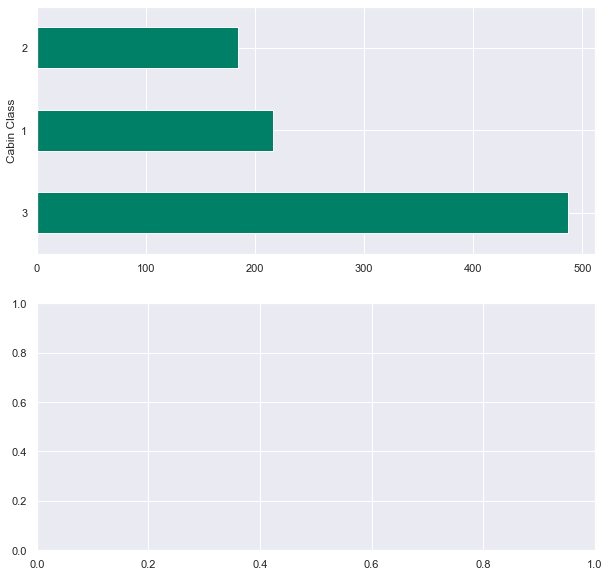

In [7]:
name = ['Cabin Class']
cabin_obj = display_data(cleaned_df, name, dimensions=(1,2))
cabin_obj.class_data()

Next we need to check if there are any NaN values

In [8]:
cleaned_df.isnull().any()

Survived                   False
Cabin Class                False
Name                       False
Sex                         True
Age                        False
Siblings/Spouses Aboard    False
Parents/Children Aboard    False
Fare                       False
dtype: bool

Find the number of null values in the sex column

In [9]:
cleaned_df['Sex'].isnull().sum()

13

There are 13 null values. for efficiency. Isolate and remove from cleaned dataframe.

In [10]:
null_df = cleaned_df[cleaned_df['Sex'].isnull()]

Change gender of NaN cells based on the persons' title

In [11]:
for index, name in enumerate(null_df['Name'].values):
    token = name.split(' ')[0].strip('.')
    if len(token) == 2:
        null_df['Sex'].iloc[index] = 1
    else:
        null_df['Sex'].iloc[index] = 0

C:\Users\maran\anaconda3\envs\BofE\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Remove the null values from the previus dataset

In [12]:
cleaned_df.dropna(inplace=True)

Convert categorical genders to numercal values. Feature engineer the 'Sex' column based on Name. Have a Male title be 1 and female be 0. 

In [13]:
gender_dict = {'male':1, 'female':0}
cleaned_df['Sex'] = cleaned_df['Sex'].apply(lambda x: gender_dict[x])

Add the two dataframes together.

In [14]:
cleaned_df = pd.concat([cleaned_df, null_df], axis=0)

Group the parents and siblings categories by first inspecting the boxplots

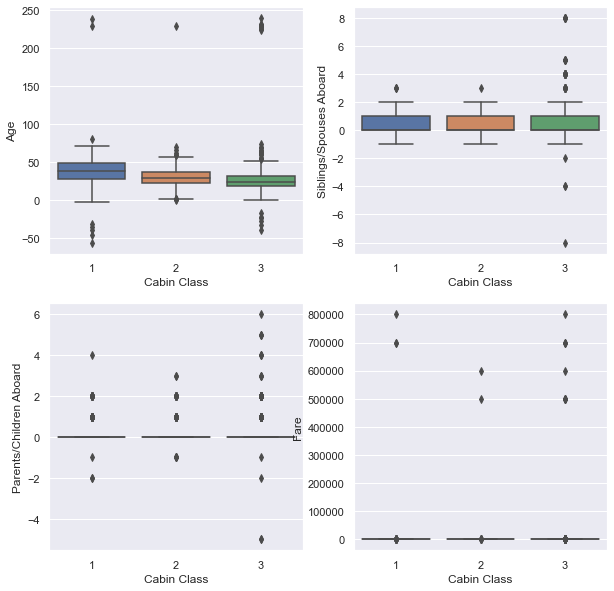

In [15]:
columns = ['Age','Siblings/Spouses Aboard','Parents/Children Aboard', 'Fare']
box_plot_obj = display_data(cleaned_df, columns, (2,2))
box_plot_obj.box_plot()

There are some ages that are negative. So inspect the negative ages in a separate dataframe. Also remember there were some ages that were greater than 100.

In [16]:
cleaned_df[cleaned_df.Age <= 0]

,Survived,Cabin Class,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
13,0,3,Mr. Anders Johan Andersson,1,-39.0,1,5,31.2750
54,1,1,Mr. Hugh Woolner,1,-46.0,0,0,35.5000
79,0,3,Mr. Achille Waelens,1,-22.0,0,0,9.0000
168,0,3,Mr. Lee Ling,1,-28.0,0,0,56.4958
173,0,1,Mr. James Clinch Smith,1,-56.0,0,0,30.6958
184,0,1,Mr. Hugh Roscoe Rood,1,-39.0,0,0,50.0000
295,0,1,Miss. Helen Loraine Allison,0,-2.0,1,2,151.5500
529,0,3,Mr. Joseph Jr Elias,1,-17.0,1,1,7.2292
569,1,1,Mr. John Irwin Flynn,1,-36.0,0,0,26.3875
629,1,1,Dr. Max Stahelin-Maeglin,1,-32.0,0,0,30.5000


The negative ages seem ok, even the age -2 has a corresponding 'Miss' so the clerk recorded them as a baby girl. 

Use the abs function to make every number positive

In [17]:
cleaned_df['Age'] = cleaned_df['Age'].apply(lambda x: abs(x))

Check for any negative ages

In [18]:
cleaned_df[cleaned_df.Age <= 0]

,Survived,Cabin Class,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare


View datapoints with ages greater than 100

In [19]:
cleaned_df[cleaned_df['Age'] > 100]

,Survived,Cabin Class,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
76,0,3,Mr. Rahamin Haim Moutal,1,228.0,0,0,8.0500
139,0,3,Mrs. Joseph (Sultana) Boulos,0,240.0,0,2,15.2458
195,0,3,Mr. Robert Mernagh,1,228.0,0,0,7.7500
293,0,1,Mr. Ervin G Lewy,1,230.0,0,0,27.7208
506,1,3,Mr. Fang Lang,1,226.0,0,0,56.4958
562,0,3,Mr. Alfred J Davies,1,224.0,-2,0,24.1500
640,1,3,Mr. Choong Foo,1,232.0,0,0,56.4958
743,1,2,Miss. Anna Sinkkonen,0,230.0,0,0,13.0000
745,0,3,Mr. Michael Connaghton,1,231.0,0,0,7.7500
752,0,3,Mr. August Sigfrid Carlsson,1,228.0,0,0,7.7958


We can either normalise the ages by subtracting 200 or remove them form the dataset. I would rather keep these datapoints as it looks like another clerical error.

In [20]:
odd_ages_df = cleaned_df[cleaned_df['Age'] > 100]
cleaned_df.drop(odd_ages_df.index.values, inplace=True)

In [21]:
cleaned_df[cleaned_df['Age'] > 100]

,Survived,Cabin Class,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare


In [22]:
odd_ages_df['Age'] = odd_ages_df['Age'].apply(lambda x: x-200)

C:\Users\maran\anaconda3\envs\BofE\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Place back in dataset

In [23]:
cleaned_df = pd.concat([cleaned_df, odd_ages_df], axis=0)

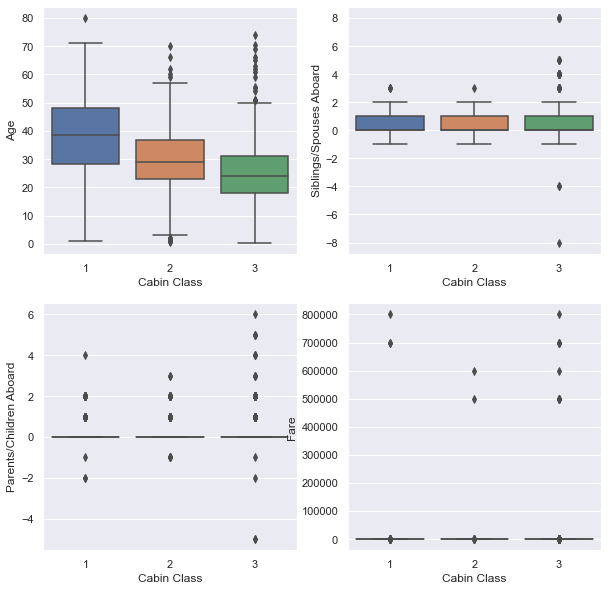

In [24]:
box_plot_obj.box_plot()

For the parents and childrens category, make the values in column positive

In [25]:
relatives = ['Siblings/Spouses Aboard','Parents/Children Aboard']
for column in relatives:
    cleaned_df[column] = cleaned_df[column].apply(lambda x: abs(x))

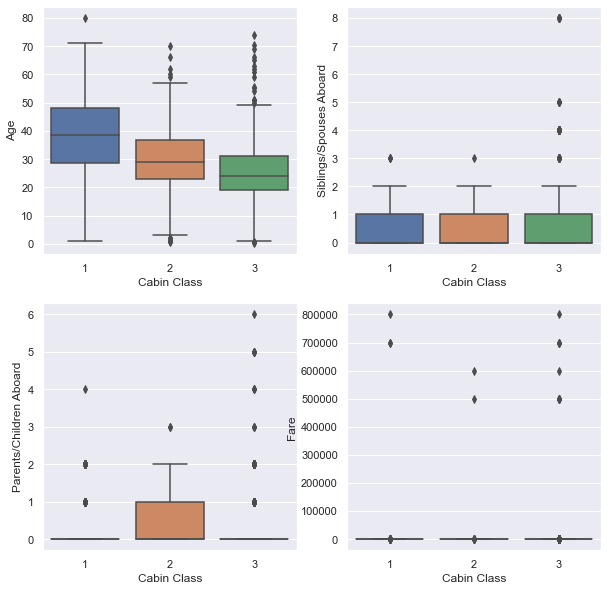

In [26]:
columns = ['Age','Siblings/Spouses Aboard','Parents/Children Aboard', 'Fare']
box_plot_obj = display_data(cleaned_df, columns, (2,2))
box_plot_obj.box_plot()

View Fare Data that was greater than 1000 and decide what to do

In [27]:
cleaned_df[cleaned_df['Fare'] > 1000]

,Survived,Cabin Class,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
30,0,1,Don. Manuel E Uruchurtu,1,40.0,0,0,700027.7208
53,0,1,Mr. Engelhart Cornelius Ostby,1,65.0,0,1,700061.9792
154,0,1,Mr. Charles Duane Williams,1,51.0,0,1,800061.3792
158,0,3,Master. Thomas Henry Sage,1,5.0,8,2,800069.5500
204,0,3,Miss. Telma Matilda Strom,0,2.0,0,1,700010.4625
233,0,2,Mr. Robert William Norman Leyson,1,24.0,0,0,600010.5000
279,0,3,Mr. Nils Johan Goransson Olsson,1,28.0,0,0,500007.8542
294,0,3,Mr. Mansour Hanna,1,23.5,0,0,700007.2292
372,0,3,Miss. Stina Viola Palsson,0,3.0,3,1,500021.0750
655,0,2,Mr. George Floyd Eitemiller,1,23.0,0,0,500013.0000


Most of this data seems very plausible for exampe data point 158. The 5 year old child with 8 siblings and 2 parents aboard. But if you were to divide by 10000, then fares from cabin classes 1 and 3 are similar. So just remove

In [28]:
odd_fare_df = cleaned_df[cleaned_df['Fare'] > 1000]
cleaned_df.drop(odd_fare_df.index.values, inplace=True)

In [29]:
cleaned_df[cleaned_df['Fare'] > 1000]

,Survived,Cabin Class,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare


View cleaned data representations

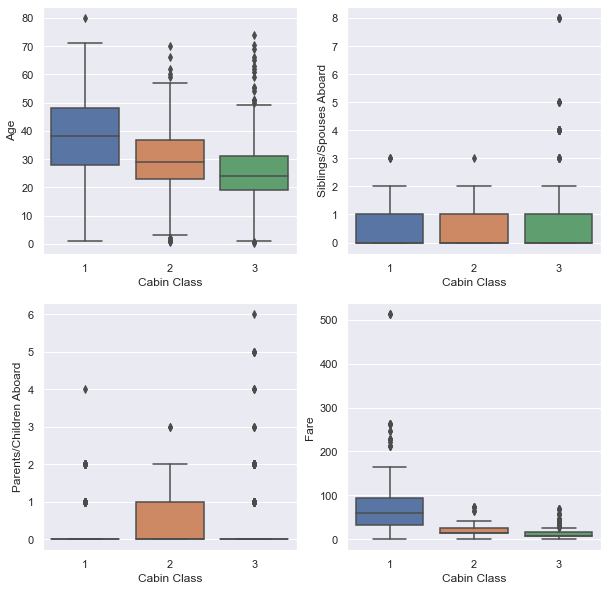

In [30]:
columns = ['Age','Siblings/Spouses Aboard','Parents/Children Aboard', 'Fare']
box_plot_obj = display_data(cleaned_df, columns, (2,2))
box_plot_obj.box_plot()

Majority of unsual fares have been removed, perhaps just remove the odd fares from the first class cabin

In [31]:
odd_fare_df = cleaned_df[cleaned_df['Fare'] > 500]
cleaned_df.drop(odd_fare_df.index.values, inplace=True)

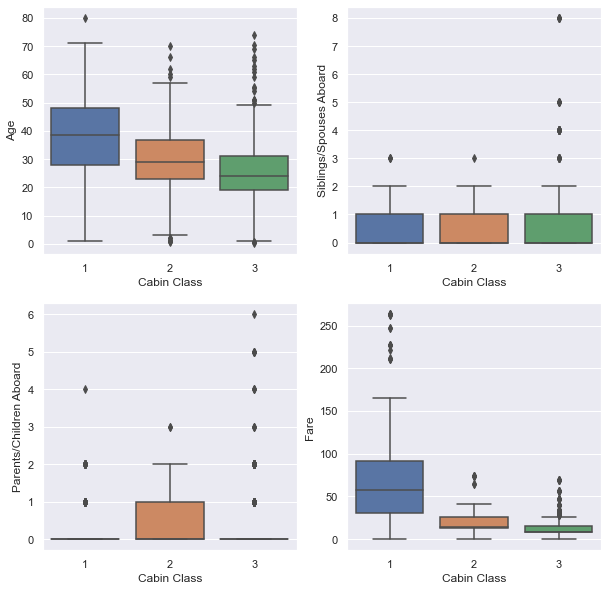

In [32]:
box_plot_obj.box_plot()

Compare Survivor counts between cabin classes.

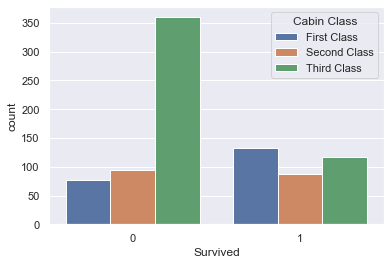

In [33]:
sns.set_theme(style="darkgrid")
cabins_plot = sns.countplot(x='Survived', data=cleaned_df, hue='Cabin Class')
plt.legend(title='Cabin Class', labels=['First Class', 'Second Class','Third Class'])
plt.show(cabins_plot)

From this, we can tell if you were in the lower classes you were far less likely to have survived, we can also view gender ratio

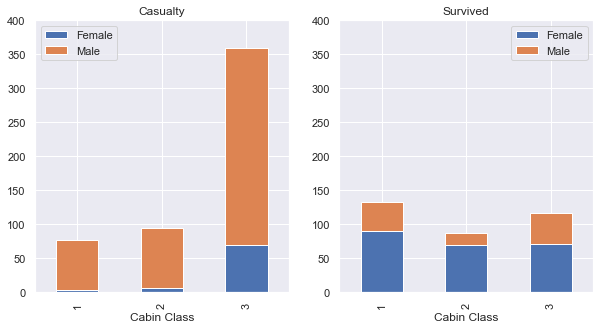

In [34]:
names = ['Casualty','Survived']
cabin_obj = display_data(cleaned_df, names, dimensions=(2,1))
cabin_obj.figsize = (10,5)
cabin_obj.grouped_data()

By breaking it down even further, men were far less likely to survive compared to women

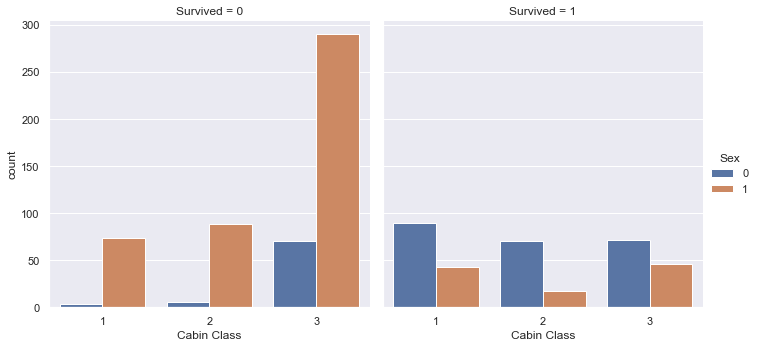

In [35]:
sns.catplot(x='Cabin Class', hue='Sex', col='Survived', data = cleaned_df, kind="count")

From unsampled data, if you were female, you were more likely to survive. From this, if you were in the 3rd class cabin, you had an extremely low survival rate

In [36]:
cleaned_df.drop('Name', axis=1, inplace=True)
undersample_num = (cleaned_df['Survived'] == 1).sum()
survivors_df = cleaned_df.loc[cleaned_df['Survived'] == 1]
casualties_df = cleaned_df.loc[cleaned_df['Survived'] == 0].sample(undersample_num)
undersampled_df = pd.concat([survivors_df.sample(frac=1), casualties_df.sample(frac=1)])

We can look at correlation matrixes for the original, clean and undersampled data.

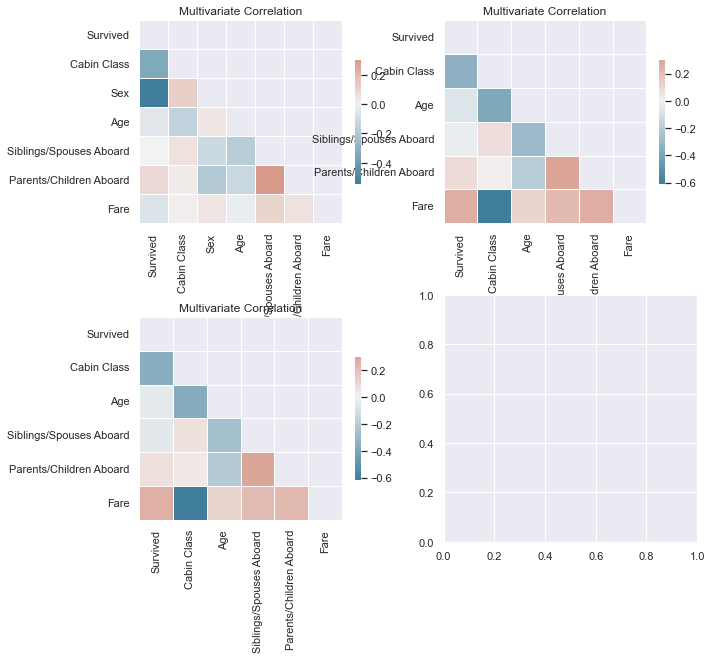

In [37]:
dfList = [original_df, cleaned_df, undersampled_df.sample(frac=1)]
cabin_obj = display_data(dimensions=(2,2))
cabin_obj.correlation_sns(dfList) 

Once the data was cleaned, there was an increase in (negative) correlation between fare price and cabin class as expected. Additionally there is a notable change with the cleaaned and undersampled dataset that the higher your fare price was, the more likey you were to survive

As stated earlier with the boxplots, a male in the lower cabins had a horrid survival rate, this can be computed with maths or a good machine learning model can be created and tested on a male or female dataset. 

There seems to be a weak correlatiion between how old you were and your likely survival rate. The 'Sex' column doesnt appear in correlation as I think the values are now numerical.

# Experiments

Below are 3 different methods of predicting survival rate. I am going to use Logistic, random forest and then a custom MLP network. As I am only predicting surival rate (binary classification), I need to split the data 4 times. Training and validation sets, probably using a built in function in the fit attribute. Then split the test set between survivors and and casualties.

So i can have two seperate confusion matrixes. In earlier experiments i kept on getting False negatives before coming to this acute realisation.

In [38]:
X = undersampled_df.drop('Survived', axis = 1)
y = undersampled_df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=undersampled_df['Survived'])

Split the test set to who survivors and casualties

In [39]:
classification_test = pd.concat([X_test,y_test],axis=1)
survivors_test_df = classification_test[classification_test.Survived == 1]
casualties_test_df = classification_test[classification_test.Survived == 0]

Split to feature and true labels

In [40]:
s_test_df_x = survivors_test_df.drop('Survived', axis = 1)
s_test_df_y = survivors_test_df.Survived
c_test_df_x = casualties_test_df.drop('Survived', axis = 1)
c_test_df_y = casualties_test_df.Survived

Create dictionary data structure for the confusion matrix method

In [41]:
df_dict = {"Casualty":[c_test_df_x, c_test_df_y], "Survived":[s_test_df_x, s_test_df_y]}

## Logistic Regression

In [42]:
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

LogisticRegression()

In [43]:
score = lr_model.score(X_test,y_test)
print('Test Accuracy Score {}'.format(score))

Test Accuracy Score 0.7980295566502463


In [44]:
kfold = KFold(n_splits=5, random_state=0, shuffle=True)
lr_cvModel = LogisticRegression(solver='liblinear')
results = cross_val_score(lr_cvModel, X_train, y_train, cv=kfold)
print("Cross validation Accuracy is: {:.2f}%".format(results.mean()*100))

Cross validation Accuracy is: 76.23%


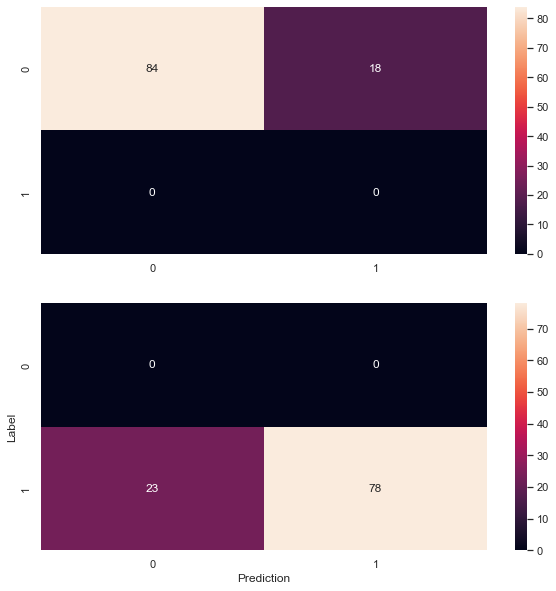

In [45]:
confusion = display_data(dimensions=(1,2))
confusion.confusion_matrix(lr_model, df_dict)

## Random Forest

In [46]:
rf_clf = RandomForestClassifier(n_estimators=100)

rf_clf.fit(X_train,y_train)

RandomForestClassifier()

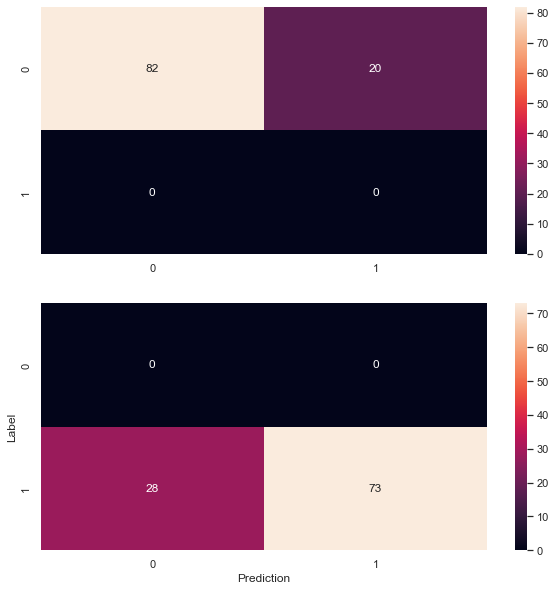

In [47]:
confusion = display_data(dimensions=(1,2))
confusion.confusion_matrix(rf_clf, df_dict)

So far, logistic regression seems to perform better than random forest classifier. Before i had seperated the test sets, random forest seemed to do better

## Multi-Layered Perceptron

In [48]:
class Custom_DenseLayer(Layer):
    def __init__(self, units=None, activation=None):
        super(Custom_DenseLayer, self).__init__()
        self.units = units
        
        self.activation = tf.keras.activations.get(activation)
        
    def build(self, input_shape):
        w_init = tf.random_normal_initializer()
        self.w = tf.Variable(name='kernel',
                initial_value=w_init(shape=(input_shape[-1],
                self.units), dtype='float32'), 
                trainable=True)
        
        b_init = tf.zeros_initializer()
        self.b = tf.Variable(name='bias',
                initial_value=b_init(shape=(self.units,),
                dtype='float32'), trainable=True)
        super().build(input_shape)
              
    def call(self, inputs):
        return self.activation(tf.matmul(inputs, self.w) + self.b)

class MLPnetwork(Model):
    def __init__(self):
        super(MLPnetwork, self).__init__()
        self.dense_1 = Custom_DenseLayer(64, 'relu')
        self.dense_2 = Custom_DenseLayer(128, 'relu')
        self.dense_3 = Custom_DenseLayer(256, 'relu')
        self.drop_1 = Dropout(0.5)
        
        self.classifier = Custom_DenseLayer(1, 'sigmoid')
        
    def call (self, inputs):
        x = self.dense_1(inputs)
        x = self.dense_2(x)
        x = self.dense_3(x)
        x = self.drop_1(x)
        return self.classifier(x)

In [49]:
mlp_model = MLPnetwork()
mlp_model.compile(loss = tf.keras.losses.BinaryCrossentropy(),
                optimizer='adam',
                 metrics=['accuracy'])

In [50]:
print(type(X_train))

<class 'pandas.core.frame.DataFrame'>


In [51]:
X_trainT = tf.convert_to_tensor(X_train, 'float32')
y_trainT = tf.convert_to_tensor(y_train)

In [52]:
history = mlp_model.fit(x=X_trainT, y=y_trainT, epochs=250, batch_size=16, validation_split=0.3)

Epoch 1/250
21/21 [==============================] - 1s 13ms/step - loss: 0.6725 - accuracy: 0.5988 - val_loss: 0.6326 - val_accuracy: 0.6268
Epoch 2/250
21/21 [==============================] - 0s 3ms/step - loss: 0.6433 - accuracy: 0.6596 - val_loss: 0.6446 - val_accuracy: 0.6197
Epoch 3/250
21/21 [==============================] - 0s 3ms/step - loss: 0.6316 - accuracy: 0.6596 - val_loss: 0.6331 - val_accuracy: 0.6268
Epoch 4/250
21/21 [==============================] - 0s 3ms/step - loss: 0.6278 - accuracy: 0.6778 - val_loss: 0.6225 - val_accuracy: 0.6549
Epoch 5/250
21/21 [==============================] - 0s 3ms/step - loss: 0.6461 - accuracy: 0.6626 - val_loss: 0.6200 - val_accuracy: 0.6549
Epoch 6/250
21/21 [==============================] - 0s 3ms/step - loss: 0.6200 - accuracy: 0.6809 - val_loss: 0.6304 - val_accuracy: 0.6338
Epoch 7/250
21/21 [==============================] - 0s 3ms/step - loss: 0.6239 - accuracy: 0.6869 - val_loss: 0.6140 - val_accuracy: 0.6690
Epoch 8/250


Epoch 59/250
21/21 [==============================] - 0s 3ms/step - loss: 0.3832 - accuracy: 0.8207 - val_loss: 0.4502 - val_accuracy: 0.8028
Epoch 60/250
21/21 [==============================] - 0s 3ms/step - loss: 0.3935 - accuracy: 0.8146 - val_loss: 0.4390 - val_accuracy: 0.7746
Epoch 61/250
21/21 [==============================] - 0s 3ms/step - loss: 0.4085 - accuracy: 0.8055 - val_loss: 0.4429 - val_accuracy: 0.7887
Epoch 62/250
21/21 [==============================] - 0s 3ms/step - loss: 0.3904 - accuracy: 0.8207 - val_loss: 0.4637 - val_accuracy: 0.7887
Epoch 63/250
21/21 [==============================] - 0s 3ms/step - loss: 0.4445 - accuracy: 0.7933 - val_loss: 0.4350 - val_accuracy: 0.7887
Epoch 64/250
21/21 [==============================] - 0s 3ms/step - loss: 0.4025 - accuracy: 0.8176 - val_loss: 0.4569 - val_accuracy: 0.7817
Epoch 65/250
21/21 [==============================] - 0s 3ms/step - loss: 0.4082 - accuracy: 0.8146 - val_loss: 0.4388 - val_accuracy: 0.7887
Epoch 

21/21 [==============================] - 0s 3ms/step - loss: 0.3558 - accuracy: 0.8298 - val_loss: 0.4977 - val_accuracy: 0.7958
Epoch 117/250
21/21 [==============================] - 0s 3ms/step - loss: 0.3270 - accuracy: 0.8389 - val_loss: 0.5135 - val_accuracy: 0.7535
Epoch 118/250
21/21 [==============================] - 0s 3ms/step - loss: 0.3162 - accuracy: 0.8419 - val_loss: 0.5281 - val_accuracy: 0.7676
Epoch 119/250
21/21 [==============================] - 0s 3ms/step - loss: 0.3280 - accuracy: 0.8541 - val_loss: 0.5176 - val_accuracy: 0.7958
Epoch 120/250
21/21 [==============================] - 0s 3ms/step - loss: 0.3407 - accuracy: 0.8480 - val_loss: 0.5387 - val_accuracy: 0.7958
Epoch 121/250
21/21 [==============================] - 0s 3ms/step - loss: 0.3520 - accuracy: 0.8298 - val_loss: 0.5211 - val_accuracy: 0.7817
Epoch 122/250
21/21 [==============================] - 0s 3ms/step - loss: 0.3118 - accuracy: 0.8693 - val_loss: 0.5029 - val_accuracy: 0.7746
Epoch 123/250

21/21 [==============================] - 0s 3ms/step - loss: 0.2786 - accuracy: 0.8906 - val_loss: 0.6260 - val_accuracy: 0.7887
Epoch 174/250
21/21 [==============================] - 0s 3ms/step - loss: 0.2743 - accuracy: 0.8632 - val_loss: 0.5650 - val_accuracy: 0.7887
Epoch 175/250
21/21 [==============================] - 0s 3ms/step - loss: 0.2588 - accuracy: 0.8784 - val_loss: 0.6641 - val_accuracy: 0.7535
Epoch 176/250
21/21 [==============================] - 0s 3ms/step - loss: 0.2540 - accuracy: 0.8906 - val_loss: 0.6604 - val_accuracy: 0.7535
Epoch 177/250
21/21 [==============================] - 0s 3ms/step - loss: 0.3032 - accuracy: 0.8663 - val_loss: 0.6230 - val_accuracy: 0.7817
Epoch 178/250
21/21 [==============================] - 0s 3ms/step - loss: 0.2877 - accuracy: 0.8693 - val_loss: 0.5960 - val_accuracy: 0.8099
Epoch 179/250
21/21 [==============================] - 0s 3ms/step - loss: 0.2509 - accuracy: 0.8936 - val_loss: 0.6200 - val_accuracy: 0.7676
Epoch 180/250

21/21 [==============================] - 0s 3ms/step - loss: 0.2358 - accuracy: 0.8967 - val_loss: 0.7213 - val_accuracy: 0.7676
Epoch 231/250
21/21 [==============================] - 0s 3ms/step - loss: 0.2218 - accuracy: 0.9027 - val_loss: 0.7282 - val_accuracy: 0.7817
Epoch 232/250
21/21 [==============================] - 0s 3ms/step - loss: 0.2215 - accuracy: 0.8967 - val_loss: 0.7178 - val_accuracy: 0.7887
Epoch 233/250
21/21 [==============================] - 0s 3ms/step - loss: 0.2139 - accuracy: 0.8906 - val_loss: 0.7808 - val_accuracy: 0.7817
Epoch 234/250
21/21 [==============================] - 0s 3ms/step - loss: 0.2510 - accuracy: 0.8936 - val_loss: 0.7306 - val_accuracy: 0.7887
Epoch 235/250
21/21 [==============================] - 0s 3ms/step - loss: 0.2313 - accuracy: 0.8997 - val_loss: 0.7749 - val_accuracy: 0.7746
Epoch 236/250
21/21 [==============================] - 0s 3ms/step - loss: 0.2159 - accuracy: 0.8967 - val_loss: 0.8117 - val_accuracy: 0.7606
Epoch 237/250

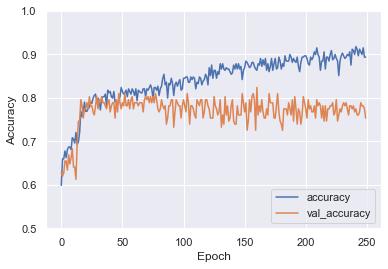

In [53]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

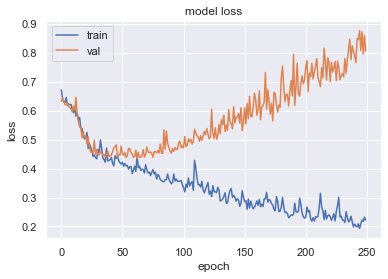

In [54]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Convert data to tensor format in new dictionary

In [55]:
df_dict = {"Casualty":[tf.convert_to_tensor(c_test_df_x, dtype='float32'), tf.convert_to_tensor(c_test_df_y)],
            "Survived":[tf.convert_to_tensor(s_test_df_x, dtype='float32'), tf.convert_to_tensor(s_test_df_y)]}

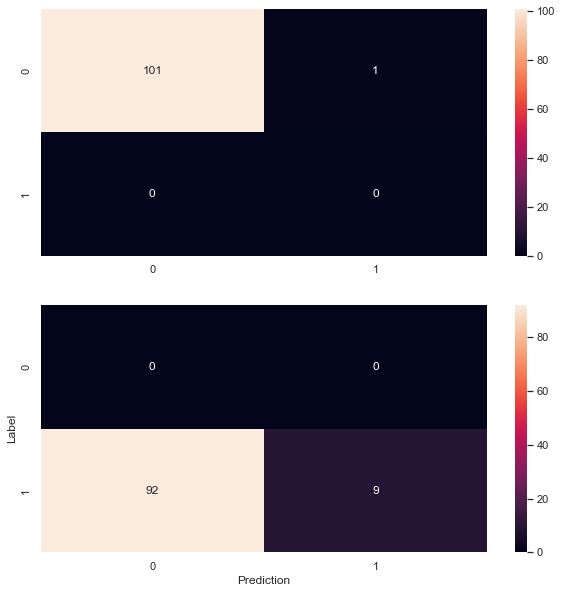

In [56]:
confusion = display_data(dimensions=(1,2))
confusion.confusion_matrix(mlp_model, df_dict)

The MLP network is actually even worser than the random forest classifier, particulary when it comes to the recall of detecting surivors